## Imports

In [1]:
import yaml
import os
from pathlib import Path
import pandas as pd
import struct
import random
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import re

# also: cd hammer && pip install -e . 

## Setup

In [2]:
# experiment setup
PDK = 'sky130'
CLOCK_PERIOD = 10 if PDK == 'sky130' else 2 # ns

# generate custom make str for each test
make_extra = f"pdk={PDK}"
if PDK == 'intech22': make_extra += f" PDK_CONF=experiments/intech22.yml"

# useful paths
energy_char_dpath = Path(os.getcwd()).parent
tests_dpath = energy_char_dpath/f'experiments/tests-{PDK}'
tests_dpath

PosixPath('/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130')

## Global Vars

In [3]:
# get pdk clock periods, paths
PDKs = ["sky130"]
test_paths = {}
for pdk in PDKs:
    test_paths[pdk] = energy_char_dpath/f'experiments/tests-{pdk}'

operations = ['add', 'mul', 'fpu_adder']
op_to_inst = {'add':'adder0', 'mul':'multiplier0', 'fpu_adder':'fpu_adder'}
clock_name = {'add':'clock', 'mul':'clock', 'fpu_adder':'clk'}
num_inputs = 50
widths = [8, 16, 32, 64]
activity_factors = [0.1, 0.3, 0.7, 1.0]
mantissa = {8:3, 16:10, 32:23, 64:52}
exponent = {8:4, 16:5, 32:8, 64:11}
bias = {8:7, 16:15, 32:127, 64:1023}
float_to_bin = {}
clock_periods = [CLOCK_PERIOD] # ns, clock periods to apply to all designs; eventually try sweeping this

width_to_max = {}
for i in widths:
    width_to_max[i] = (1 << i) - 1

design_minclock_dict = {}
# optional:
# design_minclock_dict={'add4': 4, 'add8': 4, 'add16': 4, 'add32': 4, 'add64': 4, 'mul4': 5, 'mul8': 5, 'mul16': 6, 'mul32': 6, 'mul64': 5}

'''
tests dict
  name format: <design>-<test_name>
      inputs: list, where each item is a tuple of items per line in input.txt
      defines: for verilog
'''

'\ntests dict\n  name format: <design>-<test_name>\n      inputs: list, where each item is a tuple of items per line in input.txt\n      defines: for verilog\n'

## Functions for Test Generation

In [4]:
    ## get an integer's binary string
    def getBinary(num, width):
        binary_str = ""
        for i in range(width):
            if (num & (1 << i)):
                binary_str += '1'
            else:
                binary_str += '0'
        return binary_str[::-1]

    ## get a binary's integer
    def convertStrToInt(binary):
        ret = 0
        binary = binary[::-1]
        for i in range(len(binary)):
            if (binary[i] == '1'):
                ret += pow(2, i)
        return ret

    ## convert binary string to fpu
    def convertStrToFPU(bin):
        ## edge cases
        if (bin == '0' * len(bin)):
            float_to_bin[(0, len(bin))] = bin
            return 0
        if (bin == '1' * len(bin)):
            float_to_bin[(-float('inf'), len(bin))] = bin
            return -float('inf')
        if (bin == '0' + '1' * (len(bin) - 1)):
            float_to_bin[(float('inf'), len(bin))] = bin
            return float('inf')
        
        mantissa_len = mantissa[len(bin)]
        exponent_len = exponent[len(bin)]
        exp_bias = bias[len(bin)]
        exponent_val = pow(2, (convertStrToInt(bin[1:1+exponent_len]) - exp_bias))
        sign = pow(-1, (0 if bin[0] == '0' else 1))
        mantissa_str = bin[1+exponent_len:1+exponent_len+mantissa_len]
        frac_val = 1.0
        for i in range(len(mantissa_str)):
            if (mantissa_str[i] == '1'):
                frac_val += pow(2, -(i + 1))
        ret = sign * exponent_val * frac_val
        float_to_bin[(ret, len(bin))] = bin
        return ret


    ## flip the output (cur_str) given the width and activity factor (prob)
    def flip_str(cur_str, width, prob):
        ret = ''
        for i in range(width):
            on = (cur_str[i] == '1')
            rand_num = random.random()
            ## flip bit
            if (rand_num <= prob):
                ret += ('1' if not on else '0')
            else:
                ret += ('1' if on else '0')
        return ret

    ## flip the output (cur_num) given the width and activity factor (prob)
    def flip_num(cur_num, width, prob):
        ret = 0
        for i in range(width):
            on = ((cur_num & (1 << i)) > 0)
            rand_num = random.random()
            ## flip bit
            if (rand_num <= prob):
                ret += ((not on) * (1 << i))
            else:
                ret += (on * (1 << i))
        return ret

    ## find (a, b) s.t. a + b = num
    def findNums(num, operation):
        a, b = 0, 0
        if (operation == 'add'):
            a = random.randint(0, num)
            b = num - a
        elif (operation == 'mul'):
            a, b = 1, num
        elif (operation == 'fpu_adder'):
            a, b = 0, num
        return (a, b)


    def getInputs(width, activity_factor, num_iter, operation):
        nums = [(0, 0)]
        lastBinStr = '0' * width
        for i in range(num_iter - 1):
            if (operation == 'add'):
                new_num = flip_num(sum(nums[-1]), width, activity_factor)
                nums.append(findNums(new_num, operation))
            elif (operation == 'mul'):
                new_num = flip_num(nums[-1][0] * nums[-1][1], width, activity_factor)
                nums.append(findNums(new_num, operation))
            elif (operation == 'fpu_adder'):
                new_str = flip_str(lastBinStr, width, activity_factor)
                fpu_val = convertStrToFPU(new_str)
                nums.append(findNums(fpu_val, operation))
                lastBinStr = new_str
        return nums

## YAML Config

In [5]:
def writeYaml(td):
    defines_str = '\n'.join( [ f"  - {key}={val}" for key,val in td['defines'].items() ] )
    clock_period = td["clock_period"]
    delays = [f"""{{name: {i}, clock: {td['clock']}, delay: "1", direction: input}}""" for i in td['input_ports']]
    delays += [f"""{{name: {i}, clock: {td['clock']}, delay: "1", direction: output}}""" for i in td['output_ports']]
    delays = ',\n  '.join(delays)
    cfg = f"""\
vlsi.core.build_system: make
vlsi.inputs.power_spec_type: cpf
vlsi.inputs.power_spec_mode: auto

design.defines: &DEFINES
  - CLOCK_PERIOD={clock_period}
{defines_str}

vlsi.inputs.clocks: [{{name: {td['clock']}, period: "{clock_period}ns", uncertainty: "100ps"}}]

vlsi.inputs.delays: [
  {delays}
]

synthesis.inputs:
  top_module: {td['top_module']}
  input_files: {td['vsrcs']}
  defines: *DEFINES

sim.inputs:
  top_module: {td['top_module']}
  tb_name: {td['tb_name']}
  tb_dut: {td['tb_dut']}
  options: ["-timescale=1ns/10ps", "-sverilog"]
  options_meta: append
  defines: *DEFINES
  defines_meta: append
  level: rtl
  input_files: {td['vsrcs'] + td['vsrcs_tb']}

vlsi.core.power_tool: hammer.power.joules
power.inputs:
  level: rtl
  top_module: {td['top_module']}
  tb_name: {td['tb_name']}
  tb_dut: {td['tb_dut']}
  defines: *DEFINES
  input_files: {td['vsrcs']}
  report_configs:
    - waveform_path: {td['root']}/output.fsdb
      report_stem: {td['root']}/power
      toggle_signal: {td['clock']}
      num_toggles: 1
      levels: all
      output_formats:
      - report
      - plot_profile
      - ppa
"""
    with (td['root']/'config.yml').open('w') as f:
        f.write(cfg)

## Functions for Creating Tests

In [6]:
def decimalFormat(factor):
    sf = str(factor).replace('.','p')
    return sf

def createTest(operation, width, factor, clock_period):
    design = f"{operation}{width}-{clock_period}ns"
    test_name = f'{design}-{decimalFormat(factor)}'

    ## set inputs
    new_test = {'inputs': getInputs(width, factor, num_inputs, operation), 'defines': dict(WIDTH=width)}

    new_test['operation'] = operation
    new_test['width'] = width
    new_test['mantissa'] = mantissa[width]
    new_test['exponent'] = (width - mantissa[width] - 1)
    new_test['output_af'] = factor

    ## verilog info
    new_test['design'] = design
    new_test['inst'] = f'/{op_to_inst[operation]}' if operation == 'fpu_adder' else f'/{operation}/{op_to_inst[operation]}'
    new_test['clock'] = clock_name[operation]
    new_test['vsrcs'] = [f'src/{operation}.v']
    new_test['vsrcs_tb'] = [f'src/{operation}_tb.v']
    new_test['top_module'] = f'{operation}'
    new_test['tb_name'] = f'{operation}_tb'
    new_test['tb_dut'] = f'{operation}_dut'
    new_test['input_ports'] = ['in0','in1']
    new_test['output_ports'] = ['out']
    new_test['clock_period'] = clock_period
    new_test['input_format'] = 'float' + str(width)

    ## root dir
    root = tests_dpath/test_name
    root.mkdir(exist_ok=True,parents=True)
    new_test['defines']['TESTROOT'] = root
    if (operation == 'fpu_adder'):
        new_test['defines']['MANTISSA'] = mantissa[width]
        new_test['defines']['EXPONENT'] = exponent[width]
    new_test['root'] = root

    ## design dir
    new_test['obj_dpath'] = energy_char_dpath/f"build-{PDK}-cm/{design}"

    cfg = str(new_test['root']/'config.yml')
    new_test['make'] = f"design={new_test['design']} {make_extra} DESIGN_CONF={cfg}"

    return test_name, new_test

# convert data operands to binary format to dump to input.txt (gets more complicated for floats)
def val2binary(val,width) -> str:
    if type(val) == str: return val
    elif type(val) == int: return '{0:b}'.format(val)
    elif type(val) == float:
        return float_to_bin[(val, width)]
    else: assert(False), f"Invalid dtype, {type(val)}"

## write inputs to test file
def writeInput(test_info):
    with (test_info['root']/'input.txt').open('w') as f:
        for operands in test_info['inputs']:
            f.write(" ".join([val2binary(operand,test_info['width']) for operand in operands]) + '\n')

## Generate All Tests

In [7]:
tests_dict = {}
for operation in operations:
    for width in widths:
        design = operation+str(width)
        design_clock_periods = clock_periods.copy()
        if design in design_minclock_dict:
            design_clock_periods.append(design_minclock_dict[design])
        for clock_period in design_clock_periods:
            for factor in activity_factors:
                test_name, test_info = createTest(operation, width, factor, clock_period)
                writeInput(test_info)
                writeYaml(test_info)
                tests_dict[test_name] = test_info

## Run Experiments

In [8]:
# Setup
def runMakeCmd(make_target,td,fp,overwrite=False,verbose=False):
    if overwrite or not fp.exists():
        cmd = f"make {make_target} {td['make']}"
        print(f'Executing commmand: {cmd}')
        subprocess.run(cmd, cwd=energy_char_dpath,
                        shell=True, check=True, capture_output=(not verbose))

# subprocess.run starts in an empty environment, need to ensure it can find hammer-vlsi
python_exec_fpath = Path(sys.executable)
env_dpath = str(python_exec_fpath.parent)
if not os.environ['PATH'].startswith(env_dpath): os.environ['PATH'] = env_dpath + ':' + os.environ['PATH']

def runBuild(td,overwrite=False,verbose=False):
    runMakeCmd("build -B",td,
                td['obj_dpath'],
                overwrite,verbose)

def runSim(td,overwrite=False,verbose=False):
    runMakeCmd("redo-sim-rtl",td,
                td['root']/'output.fsdb',
                overwrite,verbose)

def runPowerSyn(td,overwrite=False,verbose=False):
    runMakeCmd("power-rtl",td,
                td['obj_dpath']/'power-rtl-rundir/pre_report_power',
                overwrite,verbose)

def runPowerReport(td,overwrite=False,verbose=False):
    runMakeCmd("redo-power-rtl args='--only_step report_power'",td,
                td['root']/'power.power.rpt',
                overwrite,verbose)


In [9]:
# build
overwrite = True
build_dpaths = {td['obj_dpath']: t for t,td in tests_dict.items()} # run build once per build dir (not once per test)
for bd,t in build_dpaths.items():
    runBuild(tests_dict[t],overwrite)

Executing commmand: make build -B design=add8-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add8-10ns-1p0/config.yml


Executing commmand: make build -B design=add16-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add16-10ns-1p0/config.yml
Executing commmand: make build -B design=add32-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add32-10ns-1p0/config.yml
Executing commmand: make build -B design=add64-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add64-10ns-1p0/config.yml
Executing commmand: make build -B design=mul8-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/mul8-10ns-1p0/config.yml
Executing commmand: make build -B design=mul16-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/mul16-10ns-1p0/config.yml
Executing commmand: make build -B design=mul32-10ns pdk=sky130 DESIGN_CONF=/bwrcq/

In [10]:
# power-rtl: synthesize design in power tool + save checkpoint
overwrite = True
for bd,t in build_dpaths.items():
    runSim(tests_dict[t],overwrite)
    runPowerSyn(tests_dict[t],overwrite)
    runPowerReport(tests_dict[t],overwrite)

Executing commmand: make redo-sim-rtl design=add8-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add8-10ns-1p0/config.yml
Executing commmand: make power-rtl design=add8-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add8-10ns-1p0/config.yml
Executing commmand: make redo-power-rtl args='--only_step report_power' design=add8-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add8-10ns-1p0/config.yml
Executing commmand: make redo-sim-rtl design=add16-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add16-10ns-1p0/config.yml
Executing commmand: make power-rtl design=add16-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add16-10ns-1p0/config.yml
Executing commmand: make redo-power-rt

## Adjust Clock Periods to Fix Timing

In [11]:
# TODO: check ppa.rpt & adjust clock period, print updated values
#       in a dict that user copies to the top? it's a bit messy but we prolly don't want to auto-loop

def parseSlack(fname):
    slacks = []
    with open(fname, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split()
            if (line[0] == 'register'):
                slacks.append(float(line[6]))
    return min(slacks)

overwrite = True
new_clocks = {}
for bd,t in build_dpaths.items():
    cur_test = tests_dict[t]
    clock_period = cur_test['clock_period']
    slack = parseSlack(cur_test['root']/'power.ppa.rpt')
    if 0 <= slack and slack < 500: slack = 0 # don't change clock period
    new_clock_period = math.floor((clock_period * 1000 - slack) / 1000)
    new_clocks[t.split('-')[0]] = new_clock_period

print(f"design_minclock_dict={new_clocks}")
# copy output to top if desired

design_minclock_dict={'add8': 4, 'add16': 4, 'add32': 4, 'add64': 4, 'mul8': 5, 'mul16': 6, 'mul32': 6, 'mul64': 5, 'fpu_adder8': 5, 'fpu_adder16': 8, 'fpu_adder32': 10, 'fpu_adder64': 8}


In [12]:
# sim-rtl
for t,td in tests_dict.items():
    runSim(td, overwrite=True, verbose=True)
    runPowerReport(td, overwrite=True, verbose=True)

Executing commmand: make redo-sim-rtl design=add8-10ns pdk=sky130 DESIGN_CONF=/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add8-10ns-0p1/config.yml
/bwrcq/C/nayiri/conda/envs/charflow/bin/hammer-vlsi -e /bwrcq/scratch/nayiri/hammer-sep24/e2e/configs-env/bwrc-env.yml -p /bwrcq/scratch/nayiri/hammer-sep24/e2e/configs-pdk/sky130.yml -p /bwrcq/scratch/nayiri/hammer-sep24/e2e/configs-tool/cm.yml -p /bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add8-10ns-1p0/config.yml -p /bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/build-sky130-cm/add8-10ns/sram_generator-output.json  -p /bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/../configs-pdk/sky130.yml  -p /bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/../configs-tool/cm.yml  -p /bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130/add8-10ns-0p1/config.yml -p /bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-ch

        : The library level attribute default_operating_conditions on line 4752 is defined after at least one cell definition. The attribute will be ignored. (File /tools/C/openeda/conda-sky130/share/pdk/sky130A/libs.ref/sky130_fd_io/lib/sky130_fd_io__top_gpiov2_tt_tt_025C_1v80_3v30.lib)
        : Duplicate definition for attribute 'always_on' encountered. The last definition will be retained. (File /tools/C/openeda/conda-sky130/share/pdk/sky130A/libs.ref/sky130_fd_io/lib/sky130_fd_io__top_ground_lvc_wpad_tt_025C_1v80_3v30.lib, Line 191)
        : The library level attribute default_operating_conditions on line 869 is defined after at least one cell definition. The attribute will be ignored. (File /tools/C/openeda/conda-sky130/share/pdk/sky130A/libs.ref/sky130_fd_io/lib/sky130_fd_io__top_xres4v2_tt_tt_025C_1v80_3v30.lib)

  Message Summary for Library all 17 libraries:
  *********************************************
  Missing pg_pin group in the library. [LBR-702]: 6
  Missing a functi

In [33]:
def parse_hier_power_rpt(td) -> list:
    fpath = td['root']/'power.hier.power.rpt'
    with fpath.open('r') as f: lines = f.readlines()
    for l in lines:
        words = l.split()
        if l.startswith('Power Unit'):
            assert(words[-1] == 'mW'), f"Wrong power unit in report, {l}"
        if td['inst'] == words[-1]:
            # print([float(p) for p in words[2:6]])
            return [float(p) for p in words[2:6]]
    return []

def parse_power_profile(td) -> float:
    fpath = td['root']/'power.profile.png.data'
    with fpath.open('r') as f: lines = f.readlines()
    header = lines[0]
    assert((f"-ykeylabel {td['inst']}:total:total" in header) or (f"-ykeylabel {td['inst'][1:]}:total:total" in header)) # make sure we got the correct power trace
    match = re.search(r'simulation time \((\w+)\)', header)
    unit = match.group(1) if match else None
    if unit == 'ns': scaling = 1
    elif unit == 'ps': scaling = 1e-3
    elif unit == 'fs': scaling = 1e-6
    else: raise ValueError(f"Unit {unit} not supported in file {fpath}")
    time_power = [l.split() for l in lines]
    time_power = [tp for tp in time_power if len(tp) == 2]
    times = [float(t)*scaling for t,p in time_power]
    powers = [float(p) for t,p in time_power][1:-1] # skip first/last values bc they're misleading
    avgpow = sum(powers)/len(powers)
    return times[-1]-times[0], avgpow # end-start


power = []

for t,td in tests_dict.items():
    power.append(parse_hier_power_rpt(td))

power = pd.DataFrame(power,   #  mW
                     columns=['Leakage','Internal','Switching','Total'],
                     index=tests_dict.keys()) # type: ignore

database = pd.DataFrame()
database['tests'] = tests_dict.keys()
database = database.set_index('tests')

database['design'] = [t.split('-')[0] for t in tests_dict]
database['clock']  = [t.split('-')[1] for t in tests_dict]
database['output_af']  = [td['output_af'] for td in tests_dict.values()]

time_ns = [parse_power_profile(td)[0] for td in tests_dict.values()]
energy = power.mul(time_ns,axis=0) / num_inputs # mW * ns = pJ
energy.columns = [c+' Energy (pJ)' for c in energy.columns]

database['time_ns']  = time_ns
database = pd.concat([database,energy,power],axis=1)


database.to_hdf(PDK+'.h5',key='df',mode='w')
database


,design,clock,output_af,time_ns,Leakage Energy (pJ),Internal Energy (pJ),Switching Energy (pJ),Total Energy (pJ),Leakage,Internal,Switching,Total
add8-10ns-0p1,add8,10ns,0.1,505.0,0.000002,0.180028,1.300102,1.480135,1.488270e-07,0.017825,0.128723,0.146548
add8-10ns-0p3,add8,10ns,0.3,505.0,0.000002,0.301954,4.074118,4.376067,1.487430e-07,0.029896,0.403378,0.433274
add8-10ns-0p7,add8,10ns,0.7,505.0,0.000002,0.437332,8.531450,8.968780,1.492300e-07,0.043300,0.844698,0.887998
add8-10ns-1p0,add8,10ns,1.0,505.0,0.000002,0.551280,12.771753,13.323011,1.485900e-07,0.054582,1.264530,1.319110
add16-10ns-0p1,add16,10ns,0.1,505.0,0.000003,0.404245,3.052806,3.457058,3.199540e-07,0.040024,0.302258,0.342283
add16-10ns-0p3,add16,10ns,0.3,505.0,0.000003,0.594791,7.354749,7.949548,3.234190e-07,0.058890,0.728193,0.787084
add16-10ns-0p7,add16,10ns,0.7,505.0,0.000003,0.989588,18.453710,19.443207,3.215250e-07,0.097979,1.827100,1.925070
add16-10ns-1p0,add16,10ns,1.0,505.0,0.000003,1.188043,25.657434,26.845497,3.076190e-07,0.117628,2.540340,2.657970
add32-10ns-0p1,add32,10ns,0.1,505.0,0.000008,1.014474,6.230478,7.244972,7.586290e-07,0.100443,0.616879,0.717324
add32-10ns-0p3,add32,10ns,0.3,505.0,0.000008,1.390528,17.132226,18.522794,7.652950e-07,0.137676,1.696260,1.833940


## Generate Energy vs. Activity Factor Plot

In [39]:
tests_dict['add16-10ns-0p1'].keys()
tests_dict['fpu_adder8-10ns-0p3']['operation']

'fpu_adder'

''

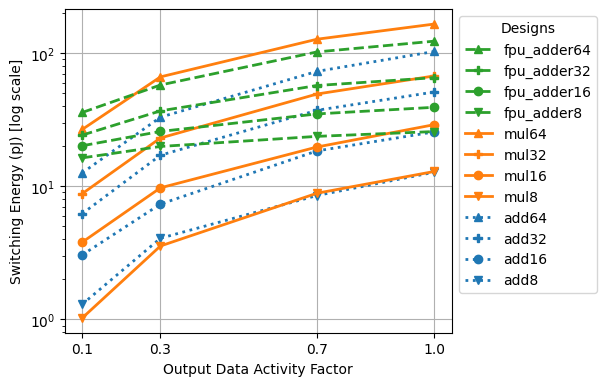

In [97]:
ykey = 'Switching Energy (pJ)'
# ykey = 'Internal (pJ)'

plt.figure(figsize=(5,4.2))

width_markers = {8: 'v', 16: 'o', 32:'P', 64: '^'}
operation_colors = dict(add='tab:blue',mul='tab:orange',fpu_adder='tab:green')
operation_linestyles = dict(add=':',mul='-',fpu_adder='--')

designs =  list(dict.fromkeys(database['design']).keys())
for design in designs:
    df = database[~database['output_af'].isna() & (database['design'] == design)].sort_values('output_af')
    hd = df['output_af']
    t = df.index[0]
    width = tests_dict[t]['width']
    op = tests_dict[t]['operation']
    e = df[ykey]
    plt.plot(hd,e,label=design,
            color=operation_colors[op],
            linewidth=2,
            linestyle=operation_linestyles[op],
            markersize=6,
            marker=width_markers[width],)
    plt.xticks(hd)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1],labels[::-1],bbox_to_anchor=(1,1),title='Designs')
plt.xlabel('Output Data Activity Factor')
plt.ylabel(ykey + ' [log scale]')
plt.grid(axis='both')
# plt.ylim(bottom=0)
plt.yscale('log')
;

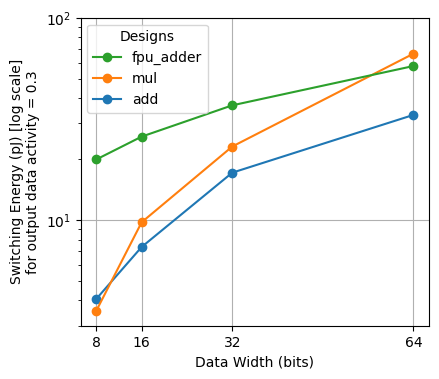

In [100]:
ykey = "Switching Energy (pJ)"

output_af = 0.3

plt.figure(figsize=(4.5,4))

data = database[database['output_af'] == output_af]
for operation in operations:
    widths, skip = [], []
    ind = 0
    for val in data['design']:
        if operation == val[:len(operation)]:
            widths.append(int(val.replace(operation,'')))
        else:
            skip.append(ind)
        ind += 1
    energies = data[ykey].values
    valid_energies = []
    for i in range(len(energies)):
        if i not in skip:
            valid_energies.append(energies[i])
    # print(widths, valid_energies)
    plt.plot(widths,valid_energies,'o-', label=operation)
    plt.xticks(widths)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1],labels[::-1],title='Designs')
# plt.legend()
plt.xlabel("Data Width (bits)")
plt.ylabel(ykey + f' [log scale]\nfor output data activity = {output_af}')
plt.grid(axis='both')
plt.ylim(3,100)
plt.yscale('log')

